In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Backgroud

Backgroud:美国某保险公司，与merkle合作多年，有一款医疗险产品主要向65岁及以上的人群推出，渠道是直邮，客户想知道哪些人更倾向于购买该医疗险产品？

以保险销售数据和电脑销售数据，介绍二元分类分决策树过程。涉及流程是：
1. 读入数据
2. 了解数据
3. 是否有重复的records，是否有缺失值以及缺失值处理
4. 变量转化：将字符型变量转化为数值型
5. 建模

   1). 数据集样本拆分：模型建立样本、样本内验证、样本外验证
   2).建立Function 用于建模和交叉验证
   
   3).找到最佳参数
   
   4).建模并且输出交叉验证结果 
   
   5).决策树结果可视化
   
 
   
   
 6.决策树规则输出：用于给人群打上标签
    

数据集：model_data_reduce_2.csv


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd,numpy as np,os,warnings
warnings.filterwarnings("ignore")
os.chdir(r"c:\Users\CDA\data")
# 解决坐标轴刻度负号乱码
plt.rcParams['axes.unicode_minus'] = False

# 解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['Simhei']

### Step1:读入数据

In [3]:
# 读入数据
data=pd.read_csv("ma_resp_data_temp.csv",sep=",",header=0)
data.head()

,KBM_INDV_ID,resp_flag,GEND,CA00,CA03,CA06,CA11,CA16,AART,ADBT,...,c210pmr,c210poo,c210psu,c210pwc,c210wht,ilor,meda,pdpe,tins,zhip19
0,281478,0,M,4,0,5,1,1,N,N,...,52,65,71.0,22,79.0,15.0,64.0,42,8,8
1,290485,0,M,0,0,0,0,0,N,N,...,44,81,99.0,37,65.0,17.0,61.0,46,6,3
2,299949,0,F,0,0,0,0,0,N,N,...,38,44,62.0,44,47.0,20.0,61.0,46,7,3
3,314635,0,F,0,4,0,0,0,N,N,...,45,71,99.0,39,71.0,4.0,62.0,37,8,9
4,363702,0,F,0,0,0,0,0,N,N,...,32,13,36.0,15,65.0,9.0,NaN,37,4,3


### Step2:了解数据 

##### 1.查看整体分布

In [5]:
# 查看数据概况
data.shape
data['KBM_INDV_ID']=data['KBM_INDV_ID'].astype('object')
data.describe().T

(43666, 76)

,count,mean,std,min,25%,50%,75%,max
resp_flag,43666.0,0.400518,0.490009,0.0,0.0,0.0,1.0,1.0
CA00,43666.0,0.267806,0.996459,0.0,0.0,0.0,0.0,6.0
CA03,43666.0,0.214034,0.886914,0.0,0.0,0.0,0.0,7.0
CA06,43666.0,0.381968,1.178281,0.0,0.0,0.0,0.0,7.0
CA11,43666.0,0.313196,1.047293,0.0,0.0,0.0,0.0,7.0
CA16,43666.0,0.224316,0.858203,0.0,0.0,0.0,0.0,7.0
LIVEWELL,43661.0,2.842125,1.172255,1.0,2.0,3.0,4.0,6.0
NOC19,43666.0,0.465717,1.045087,0.0,0.0,0.0,0.0,9.0
NAH19,43666.0,2.080818,1.215852,0.0,1.0,2.0,3.0,9.0
NPH19,43666.0,2.546535,1.903632,0.0,1.0,2.0,3.0,16.0


In [7]:
#查看因变量的比例：无偏数据
response_y_count=data['resp_flag'][data.resp_flag==1].count()
response_count=data['resp_flag'].count()
print("{:.2%}".format(response_y_count/response_count))

40.05%


##### 2. 查看各特征分布

Text(0.5, 0, 'N2NCY')

Text(0, 0.5, 'Frequency')

(60, 90)

Text(0.5, 0, 'Age')

Text(0, 0.5, 'Density')

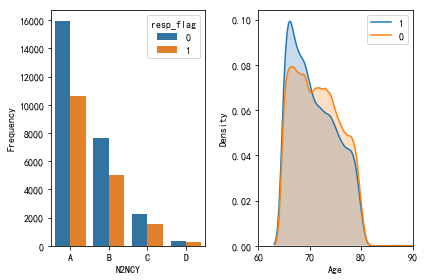

In [8]:
# 为分类型变量如'所处区的大小'，创建条形图
plt.subplot(1,2,1)  #当前画板为1行2列，当前绘制第1子图
sns.countplot(x='N2NCY', hue='resp_flag', data=data)  #设置x，x分组依据
plt.xlabel('N2NCY')
plt.ylabel('Frequency')

# 为连续型变量如'年龄',创建密度图 
plt.subplot(1, 2, 2)
sns.kdeplot(data.age[data.resp_flag==1], label='1', shade=True)
sns.kdeplot(data.age[data.resp_flag==0], label='0', shade=True)
plt.xlim(([60,90]))
plt.xlabel('Age');
plt.ylabel('Density');

plt.tight_layout() #自动调整布局
plt.show()

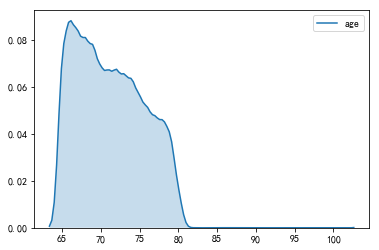

In [7]:
sns.kdeplot(data.age,shade=True)
plt.show()

<Figure size 720x216 with 0 Axes>

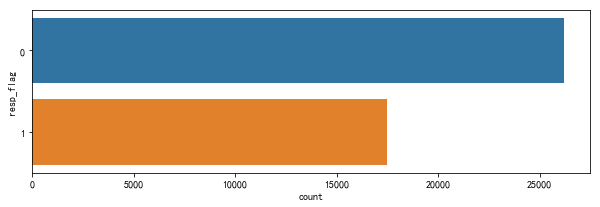

In [8]:
# 查看性别比例
plt.figure(1 , figsize = (10 , 3))
sns.countplot(y = 'resp_flag' , data = data)
plt.show()

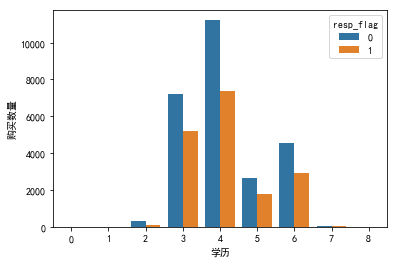

In [9]:
#查看不同的学历之间购买保险比例
sns.countplot(x='c210mys', hue='resp_flag', data=data); #设置 x,y 以及颜色控制的变量,以及画图的数据
plt.xlabel('学历');
plt.ylabel('购买数量');

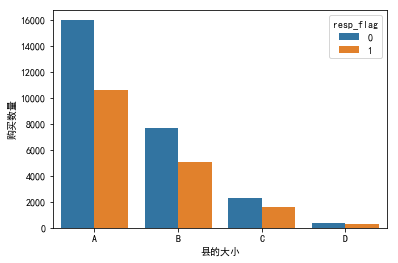

In [10]:
# 县级别和购买比例
sns.countplot(x='N2NCY', hue='resp_flag', data=data); #设置 x,y 以及颜色控制的变量,以及画图的数据
plt.xlabel('县的大小');
plt.ylabel('购买数量');

### Step3:数据清洗及整合 

##### 1. 缺失值处理

In [4]:
# 查看变量缺失值比例
NA=data.isnull().sum()
NA=NA.reset_index()
NA.columns=['Var','NA_per']
NA['NA_per']=(NA['NA_per'].values/data.shape[0])
NA=NA[NA.NA_per>0].reset_index(drop=True)
NA

,Var,NA_per
0,AASN,0.000229
1,ASKN,0.000183
2,COLLEGE,0.000183
3,MOBPLUS,0.000160
4,N2NCY,0.000229
5,NY8Y9,0.000206
6,POEP,0.000183
7,LIVEWELL,0.000115
8,HOMSTAT,0.000229
9,HINSUB,0.000252


In [13]:
# 处理缺失值
var_char_na=[]

for i in range(len(NA)):
    #删除 缺失值比例>75%且变量取值<=2
    if NA['NA_per'][i]>0.75 or len(data[NA['Var'][i]].unique())<=2 :
        del data[NA['Var'][i]]
    elif  data[NA['Var'][i]].dtypes!="object":  #数值型
        # 填充缺失值-中位数
        for_na_value = data[NA['Var'][i]].quantile(0.5)
        data[NA['Var'][i]] = data[NA['Var'][i]].fillna(for_na_value)
    #处理含缺失值的二值型字符变量
    elif data[NA['Var'][i]].dtypes=="object" and len(data[NA['Var'][i]].unique())<=3:
        data[NA['Var'][i]].fillna('N', inplace=True)
    else:
        var_char_na.append(NA['Var'][i])
#剩下未处理的含缺失值的多值型字符变量
var_char_na

['MOBPLUS', 'N2NCY', 'HOMSTAT', 'HINSUB']

##### 2. 去除重复项

In [14]:
data.drop_duplicates()  #无重复项

,KBM_INDV_ID,resp_flag,GEND,CA00,CA03,CA06,CA11,CA16,AART,ADBT,...,c210pmr,c210poo,c210psu,c210pwc,c210wht,ilor,meda,pdpe,tins,zhip19
0,281478,0,M,4,0,5,1,1,N,N,...,52,65,71.0,22,79.0,15.0,64.0,42,8,8
1,290485,0,M,0,0,0,0,0,N,N,...,44,81,99.0,37,65.0,17.0,61.0,46,6,3
2,299949,0,F,0,0,0,0,0,N,N,...,38,44,62.0,44,47.0,20.0,61.0,46,7,3
3,314635,0,F,0,4,0,0,0,N,N,...,45,71,99.0,39,71.0,4.0,62.0,37,8,9
4,363702,0,F,0,0,0,0,0,N,N,...,32,13,36.0,15,65.0,9.0,51.0,37,4,3
5,396011,0,F,0,0,0,0,0,Y,N,...,37,50,80.0,32,53.0,17.0,51.0,46,14,2
6,422834,0,F,0,0,0,0,0,N,N,...,61,92,78.0,35,75.0,21.0,51.0,46,12,7
7,438744,0,M,0,0,0,0,0,N,N,...,45,46,78.0,19,83.0,8.0,51.0,46,4,9
8,582772,0,M,4,1,3,0,0,N,N,...,30,61,78.0,25,71.0,41.0,51.0,46,9,6
9,623599,0,F,0,0,0,0,0,N,N,...,19,18,78.0,4,76.0,12.0,51.0,46,2,1


##### 3. 变量转换

In [15]:
# 删除两个无意义变量
drop_list=['STATE_NAME','KBM_INDV_ID']
for var in drop_list:
    del data[var]

In [16]:
#先把变量划分为数值型变量，二值型分类变量，多值型分类变量
var_num=[]
var_char_uniq2=[]
var_char_mul=[]
for var in list(data):
    if data[var].dtypes=='object' and len(data[var].unique())>2:
        var_char_mul.append(var)
    elif  data[var].dtypes!="object"  :
        var_num.append(var)
    else:
        var_char_uniq2.append(var) 

In [17]:
#处理多值型字符变量
for var in var_char_mul:
    temp=pd.get_dummies(data[var],prefix=var,prefix_sep='_')
    for var2 in list(temp):
        if var2 in '_nan':
            del temp[var2]  #若电脑版本不同导致没有生成缺失值列，可去掉此代码
    data=pd.concat([data,temp],axis=1)
    del data[var]

In [18]:
#二值型分类变量处理
from sklearn.preprocessing import LabelEncoder
def integer_encode(var):
    values=np.array(data[var])  #data[var].values
    label_encoder=LabelEncoder()
    data[var]=label_encoder.fit_transform(values)
for var in var_char_uniq2:
    if len(data[var].unique())<2:
        del data[var]
    else:
        integer_encode(var)

In [19]:
len(list(data))

91

In [20]:
#检查是否有遗漏
type_1=data.dtypes
type_qc=[]
for i in range(len(type_1)):
    if type_1[i]=="object":
        type_qc.append(1)
    else:
        type_qc.append(0)
sum(type_qc)

0

In [21]:
#保存处理好的数据，避免调参时重复以上工作
data.to_excel( 'fina_data.xlsx')

### Step4:建模 

In [22]:
# 引用sklearn 模块
from sklearn import tree
from sklearn.model_selection  import train_test_split
from sklearn.metrics import classification_report
#from sklearn import cross_validation, metrics
from sklearn import metrics
from sklearn.model_selection import cross_val_score
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

##### 1.将数据集分为模型样本以及验证

In [24]:
##在模型样本内将数据集7：3分，70%用来建模，30%用来测试

# 定义特征变量和目标变量
features= list(data.columns[1:]) 
X = data[features]
Y = data['resp_flag']
# 将数据集7：3分，70%用来建模，30%用来测试
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3)

In [25]:
#查看训练集和测试集Y的比例
print(Y_train.value_counts())
print(Y_test.value_counts())

0    18345
1    12221
Name: resp_flag, dtype: int64
0    7832
1    5268
Name: resp_flag, dtype: int64


##### 2.使用默认参数建立模型

In [26]:
from sklearn.metrics import accuracy_score
clf=tree.DecisionTreeClassifier()
clf.fit(X_train,Y_train)
Y_pred=clf.predict(X_test)          
print(accuracy_score(Y_test,Y_pred))
#后两行代码可替换为clf.score(X_test,Y_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

0.5882442748091603


##### 3. 调整参数

In [27]:
#决策树中参数的含义解释如下：
clf = tree.DecisionTreeClassifier(
            class_weight=None, #指定样本各类别的的权重，如果样本类别分布没有明显的偏倚，则可以不管这个参数，选择默认的"None"
            criterion='gini',#特征选择标准,可以使用"gini"或者"entropy"，前者代表基尼系数，后者代表信息增益。一般说使用默认的基尼系数"gini"就可以了，即CART算法。除非你更喜欢类似ID3, C4.5的最优特征选择方法。 
            max_depth=None,#决策树最大深,常用的可以取值10-100之间。主要是限制树的增长
            max_features=None,#划分时考虑的最大特征数
            max_leaf_nodes=None,#最大叶子节点数。通过限制最大叶。这个值限制了决策树的增长
            #min_samples_leaf=3000, #叶子节点最少样本数，用于减枝
            min_samples_split=5000,#内部节点再划分所需最小样本数，这个值限制了子树继续划分的条件
            min_weight_fraction_leaf=0.0, #叶子节点最小的样本权重和。这个值限制了叶子节点所有样本权重和的最小值，如果小于这个值，则会和兄弟节点一起被剪枝。 默认是0，就是不考虑权重问题。一般来说，如果我们有较多样本有缺失值，或者分类树样本的分布类别偏差很大，就会引入样本权重，这时我们就要注意这个值了。
            presort=False, #数据是否预排序
            splitter='best' #特征划分点选择标准,可以使用"best"或者"random"。前者在特征的所有划分点中找出最优的划分点。后者是随机的在部分划分点中找局部最优的划分点。
            )


In [28]:
clf = tree.DecisionTreeClassifier()
#参数范围设定：1.根据经验；2.开始取很小，结束取很大，步长较大；3.根据上一最优值调节
param_test={'min_samples_leaf':list(range(1000,6000,100)),'min_samples_split':list(range(4000,6000,100))}
gsearch = GridSearchCV(estimator=clf,
                       param_grid = param_test, scoring='roc_auc',n_jobs=1,iid=False, cv=5)
gsearch.fit(X_train,Y_train)
#gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_
gsearch.cv_results_, gsearch.best_params_, gsearch.best_score_

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'min_samples_leaf': [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900], 'min_samples_split': [4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900]},
       pre_dispatch='2*n_jobs', refit=True, return

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

({'mean_fit_time': array([0.14764113, 0.14608073, 0.15012064, 0.15356054, 0.13604131,
         0.14372029, 0.14824119, 0.1387208 , 0.14172106, 0.13320084,
         0.13680086, 0.14012089, 0.14008045, 0.1428823 , 0.12704091,
         0.13728027, 0.13144035, 0.13104024, 0.13104024, 0.13104024,
         0.14352021, 0.1466403 , 0.14352031, 0.15512695, 0.14136066,
         0.14352016, 0.14976029, 0.14408064, 0.13728027, 0.14040031,
         0.14348321, 0.14056063, 0.13104019, 0.13728023, 0.13104033,
         0.13416014, 0.13416018, 0.13104033, 0.13416023, 0.13104019,
         0.13728027, 0.14352021, 0.13728027, 0.1466403 , 0.13416023,
         0.14400053, 0.13728023, 0.14352036, 0.13416014, 0.14040036,
         0.13728027, 0.13416028, 0.13728023, 0.14024248, 0.13212304,
         0.14276509, 0.13668294, 0.14696617, 0.13888469, 0.146767  ,
         0.14504356, 0.15240526, 0.14200044, 0.13728018, 0.13104038,
         0.13416018, 0.13416018, 0.13204117, 0.1323204 , 0.12932119,
         0.133081

In [29]:
gsearch.best_params_
gsearch.best_score_

{'min_samples_leaf': 1400, 'min_samples_split': 4100}

0.6538033937628283

##### 4. 最终模型

In [30]:
final_model = tree.DecisionTreeClassifier(min_samples_leaf=1300,min_samples_split=4000)
final_model.fit(X_train,Y_train)
Y_pred = final_model.predict(X_test)
from sklearn.metrics import roc_auc_score
print(accuracy_score(Y_test,Y_pred))
print(roc_auc_score(Y_test,Y_pred))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1300, min_samples_split=4000,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

0.6338931297709923
0.5864663727960675


In [31]:
#思考：标准量纲：归一化；Z分
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [32]:
"""
过拟合，欠拟合
过拟合：训练集精度高，测试集低
欠拟合：训练集精度低，再看loss损失函数的曲线，随着训练次数增加，损失函数保持下降趋势为欠拟合；
        若下降一定程度后平稳则不是
"""

'\n过拟合，欠拟合\n过拟合：训练集精度高，测试集低\n欠拟合：训练集精度低，再看loss损失函数的曲线，随着训练次数增加，损失函数保持下降趋势为欠拟合；\n        若下降一定程度后平稳则不是\n'

### Step5:结果可视化

In [33]:
from sklearn.metrics import accuracy_score
clf = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 4, min_samples_leaf=1000)
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
print(accuracy_score(Y_test,Y_pred))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1000, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

0.6351908396946565


In [34]:
dot_data = tree.export_graphviz(clf
                    ,feature_names= features,
                    class_names=['No Purchase',"Purchase"],       #字符串列表形式，默认为空，指定目标类的名称
                     filled=True,                     #默认False，对节点着色以显示多数类
                     rounded=True,                    #默认为False，若为True，节点框为圆角且用赫维提卡体代替默认的罗马字体
                     #rotate=True,                    #默认为False，若为True，树将长成左右结构，而不是默认的上下结构
                     impurity=True,                   #默认为True，是否为每个节点输出不纯度
                     leaves_parallel=False,         #默认为False,是否在树的底部画出叶节点
                     node_ids=True
                               )

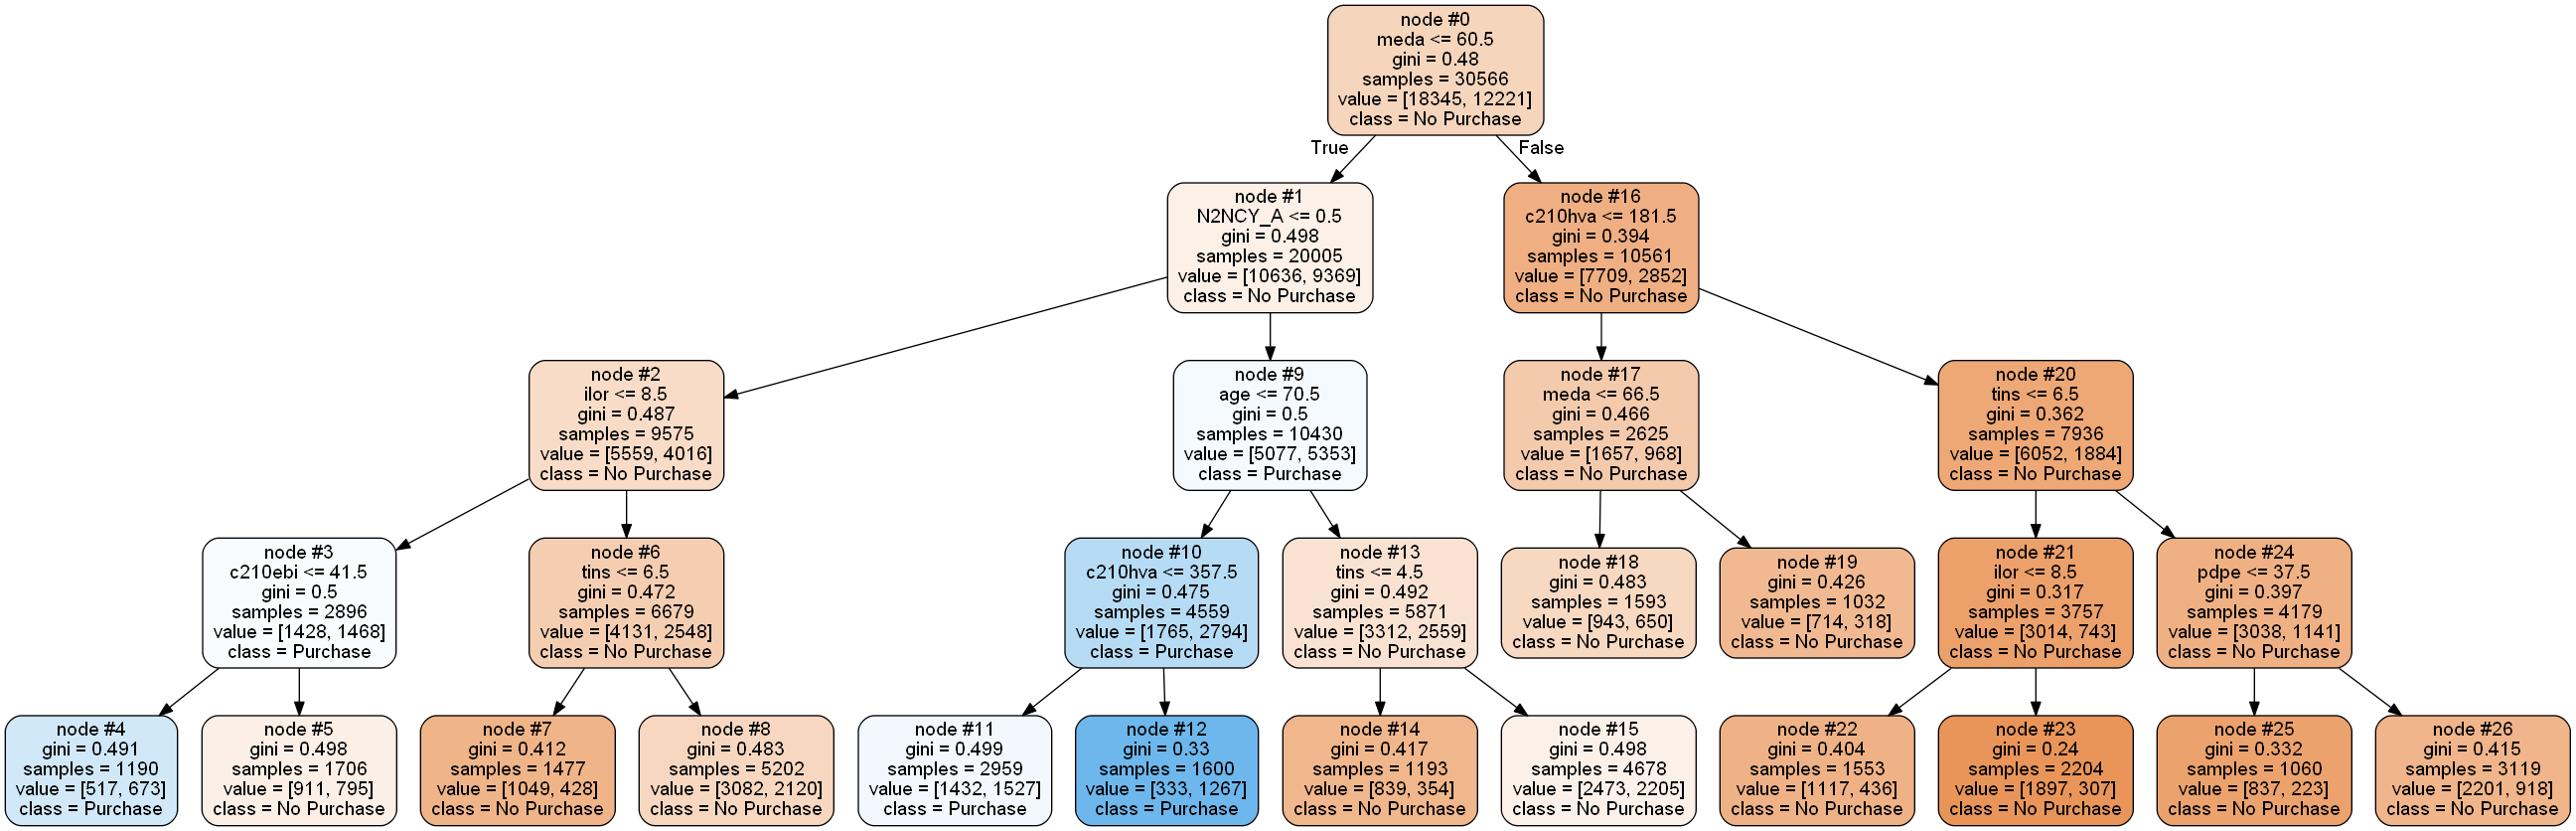

In [35]:
###第一课树的可视化过程
import os
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
#os.environ["PATH"] += os.pathsep + 'C:/Users/yacao/Downloads/graphviz-2.38/release/bin'

dot_data = StringIO()
tree.export_graphviz(clf,                             #决策树分类器,注意是上一执行命令的决策树分类器
                     out_file = dot_data,             #默认tree.dot，输出dot格式文件名称 
                     feature_names = features,        #默认None，特征的名称 
                     class_names=['No Purchase',"Purchase"],          #字符串列表形式，默认为空，指定目标类的名称
                     filled=True,                     #默认False，对节点着色以显示多数类
                     rounded=True,                    #默认为False，若为True，节点框为圆角且用赫维提卡体代替默认的罗马字体
                     #rotate=True,                    #默认为False，若为True，树将长成左右结构，而不是默认的上下结构
                     impurity=True,                   #默认为True，是否为每个节点输出不纯度
                     leaves_parallel=False,         #默认为False,是否在树的底部画出叶节点
                     node_ids=True
                    )#树的参数设置

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
#Slide49 规则变量的含义
#meda:医疗险覆盖的比例
#N2NCY_A:是否处于最大的县
#C210hva:家庭房屋价值
#pdpe:所处地区居住年限
#age:年龄
#tins:该客户被多少个名单source 包含